## Part 2 of: "learning the Q-values with a neural network" ##

In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm_notebook as tqdm
tf.keras.backend.set_floatx('float64')
from misc import *
from collections import deque
from datetime import datetime
import random

In the previous "tutorial" we show that it's possible to learn the uderlying function that relates different arms of a non-linear bandit problem.

\\ 

In this notebook we will do the same, but now we add some "context" to each arm; and still there's a nonlinear function for the mean reward relating differnt arms 

In [17]:
def Prob(alpha, beta, n):
    p0 = np.exp(-(alpha-beta)**2)
    if n == 0:
        return p0
    else:
        return 1-p0

def qval(beta, n, guess):
    #dolinar guessing rule (= max-likelihood for L=1, careful sign of \beta)
    alpha = 0.4
    pn = np.sum([Prob(g*alpha, beta, n) for g in [-1,1]])
    return Prob(guess*alpha, beta, n)/pn


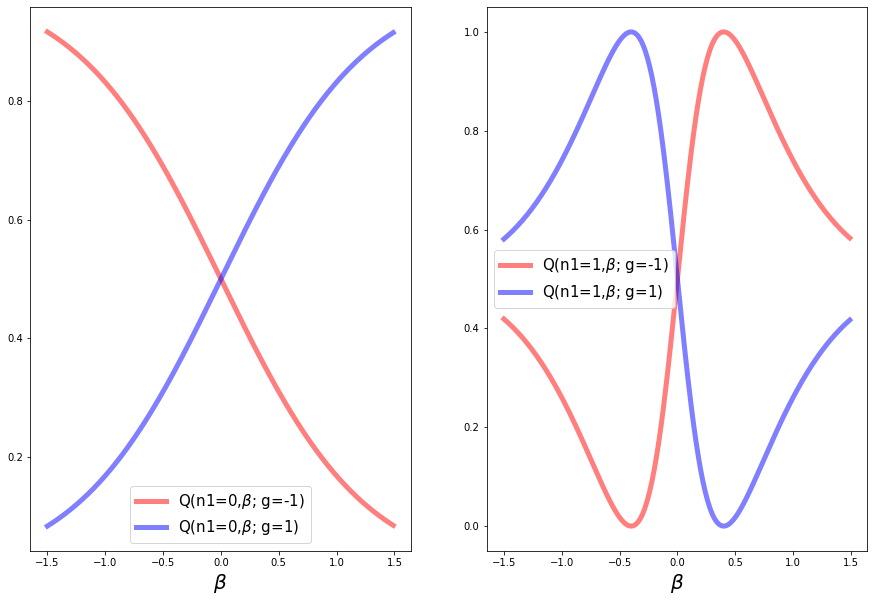

In [18]:
plt.figure(figsize=(15,10))
ax1 =  plt.subplot2grid((1,2),(0,0))
ax2 =  plt.subplot2grid((1,2),(0,1))

betas = np.arange(-1.5,1.5,.01)
ax1.plot(betas,[qval(b, 0, -1) for b in betas],alpha=0.5,c="red", linewidth=5, label="Q(n1=0,"+r'$\beta$'+"; g=-1)")
ax1.plot(betas,[qval(b, 0, 1) for b in betas],alpha=0.5,c="blue",  linewidth=5,label="Q(n1=0,"+r'$\beta$'+"; g=1)")

ax2.plot(betas,[qval(b, 1, -1) for b in betas],alpha=0.5,c="red",  linewidth=5,label="Q(n1=1,"+r'$\beta$'+"; g=-1)")
ax2.plot(betas,[qval(b, 1, 1) for b in betas],alpha=0.5,c="blue",  linewidth=5,label="Q(n1=1,"+r'$\beta$'+"; g=1)")

for ax in [ax1, ax2]:
    ax.set_xlabel(r'$\beta$', size=20)
    ax.legend(prop={"size":15})


Now let's create a dataset; the idea is to sample a reward many times for a given beta.

In [19]:
def createdataset_l2(number_rews_per_beta_per_outcome_per_guess=10**2,number_of_betas = 10):
    #we call it l2 so it does not interfer with the fist tutoral..
    dataset = []
    labels=[]
    global betas_train
    global number_of_samples
    number_of_samples = number_rews_per_beta_per_outcome_per_guess
    betas_train = np.linspace(-1.5,1.5,number_of_betas)
    for i in range(len(betas_train)):
        beta = betas_train[i]
        for outcome in [0.,1.]:
            for guess in [-1.,1.]:

                for k in range(number_rews_per_beta_per_outcome_per_guess):
                    mean_bernoulli = qval(beta, outcome, guess)
                    reward = np.random.choice([1.,0,],1,p=[mean_bernoulli, 1.-mean_bernoulli])[0]

                    dataset.append([beta, outcome, guess, reward])
    return np.array(dataset)

We can plot the data obtained, it's noisy!

Obviously, the more you sample the less noisy the average is!

In [20]:
data = createdataset_l2(10**3)
data = np.split(data, len(betas_train))

In [21]:
mean_values = {}
for index_beta in range(len(betas_train)):
    mean_values[str(index_beta)] = {}

for index_beta, beta in enumerate(betas_train):
    sp = np.split(data[index_beta],4)
    for index_ng in range(4):
        mean_values[str(index_beta)][str(index_ng)]=np.mean(sp[index_ng][:,3])

## Let's see the data! (now it's a bit more involved to plot it, as for a given beta you have some index of n and g ##

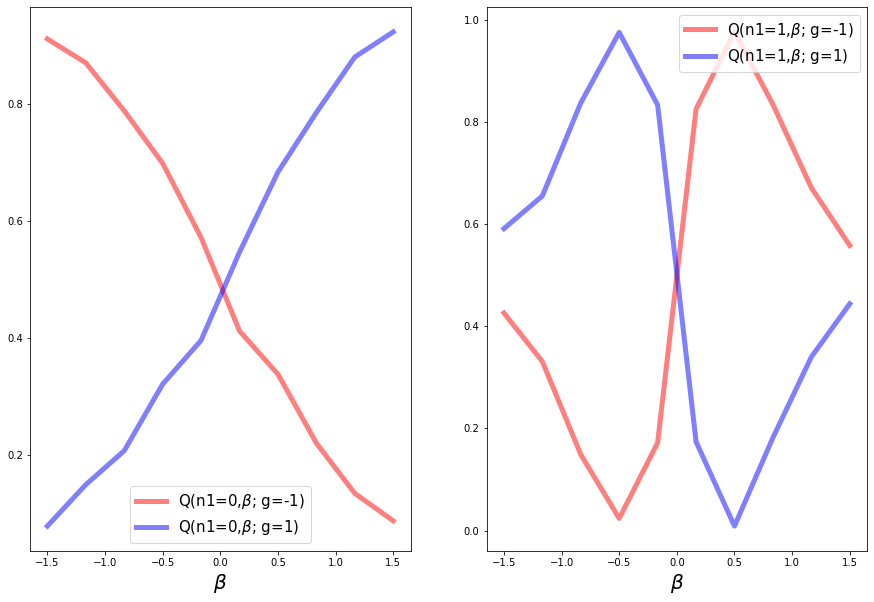

In [22]:
plt.figure(figsize=(15,10))
ax1 =  plt.subplot2grid((1,2),(0,0))
ax2 =  plt.subplot2grid((1,2),(0,1))

betas = np.arange(-1.5,1.5,.01)
ax1.plot(betas_train,[mean_values[str(b)]["0"] for b in range(len(betas_train))],alpha=0.5,c="red", linewidth=5, label="Q(n1=0,"+r'$\beta$'+"; g=-1)")
ax1.plot(betas_train,[mean_values[str(b)]["1"] for b in range(len(betas_train))],alpha=0.5,c="blue",  linewidth=5,label="Q(n1=0,"+r'$\beta$'+"; g=1)")

ax2.plot(betas_train,[mean_values[str(b)]["2"] for b in range(len(betas_train))],alpha=0.5,c="red",  linewidth=5,label="Q(n1=1,"+r'$\beta$'+"; g=-1)")
ax2.plot(betas_train,[mean_values[str(b)]["3"] for b in range(len(betas_train))],alpha=0.5,c="blue",  linewidth=5,label="Q(n1=1,"+r'$\beta$'+"; g=1)")

for ax in [ax1, ax2]:
    ax.set_xlabel(r'$\beta$', size=20)
    ax.legend(prop={"size":15})


## Now we want to train a network, defined below as Net1(), to learn this function over stochastic rewards, as we did in the case of a single $\beta$. The arquitecture we'll use is, as income, $(\beta, n, g)$ and as output $\hat{Q}(\beta, b ; g)$. ##

### Notice the difference in the input_shape=(3,) for self.l1 ##

In [6]:

class Net(tf.keras.Model):
    def __init__(self, valreg=0.01, seed_val=0.1):
        super(Net,self).__init__()

        self.l1 = Dense(50, input_shape=(3,),kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg))

        self.l2 = Dense(50, kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg),
    kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))
        self.l3 = Dense(50, kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg),
    kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

        self.l4 = Dense(50, kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg),
    kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

        self.l5 = Dense(1, kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg),
    kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

    def call(self, input):
        feat = tf.nn.relu(self.l1(input))
        feat = tf.nn.dropout(feat, rate=0.01)
        feat = tf.nn.relu(self.l2(feat))
        feat = tf.nn.dropout(feat, rate=0.01)
        feat = tf.nn.relu(self.l3(feat))
        feat = tf.nn.relu(self.l4(feat))
        feat = tf.nn.sigmoid(self.l5(feat))
        return feat

    def predict(self, history_one):
        inp = np.expand_dims(history_one, axis=0)
        return np.squeeze(self(inp).numpy())

    def __str__(self):
        return self.name


## How do we feed the network with this food ? ##

In [21]:
data[0]

array([[-1.5,  0. , -1. ,  1. ],
       [-1.5,  0. , -1. ,  1. ],
       [-1.5,  0. , -1. ,  1. ],
       ...,
       [-1.5,  1. ,  1. ,  0. ],
       [-1.5,  1. ,  1. ,  1. ],
       [-1.5,  1. ,  1. ,  0. ]])

In [26]:
food =data[0][:,[0,1,2]]

In [31]:
print(food[:5])

[[-1.5  0.  -1. ]
 [-1.5  0.  -1. ]
 [-1.5  0.  -1. ]
 [-1.5  0.  -1. ]
 [-1.5  0.  -1. ]]


In [32]:
net= Net()
net(food)[:5]

<tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[0.50630818],
       [0.50633824],
       [0.50633824],
       [0.50633824],
       [0.50634624]])>

** comment **: the difference in the values is due to the drop-out rate!

### Now that we are convinced we can learn the mean value of a (parametrized) distibution from noisy data, let's see how this get affected if we shuffle the data points (each batch is comoposed from different values of displacements).###

\\



### Notice also that the results are even **better**!###

In [10]:
def learning_problem(rews_per_beta, epochs=30, number_of_splits=10, number_of_betas=10, lr=10**(-3), batch_size=None):
    start = datetime.now()
    optimizer = tf.keras.optimizers.Adam(lr=lr)

    global dataset, net
    dataset = createdataset_l2(rews_per_beta, number_of_betas=number_of_betas)
    dataset_copy = dataset.copy()
    np.random.shuffle(dataset)
    
    if batch_size == None:

        batch_size_here = len(dataset)/number_splits
        dataset = np.split(dataset, number_of_splits + len(dataset)%number_of_splits) #spliting the dataset!
    else:
        splits = len(dataset)/batch_size
        batch_size_here = batch_size
        dataset = np.split(dataset, splits + len(dataset)%splits) #spliting the dataset!
    print("Real number of splits (len(dataset) after spliting): {}\nlen(data[0]: {}\nBatch size: {}\nepochs: {}\nNumber_of_betas: {}\nrews_per_beta: {}\nNumber of data points: {}".format(
            len(dataset),len(dataset[0]),batch_size_here,epochs,number_of_betas,rews_per_beta,rews_per_beta*4*number_of_betas)
         )
    print("")
    net = Net()
    net(dataset[0][:,[0,1,2]])
    
    histo_preds = {} #here i save the predictions
    ee = {"0":[]}
    for k in net.trainable_variables:
        ee["0"].append(k)
    for epoch in tqdm(range(epochs)):
        epoch_loss_avg = tf.keras.metrics.Mean()

        for batch in tqdm(dataset):
            with tf.GradientTape() as tape:
                tape.watch(net.trainable_variables)
                preds = net(batch[:,[0,1,2]]) #make predictions in batch
                rews = batch[:,3]
                loss = tf.keras.losses.MSE(rews,preds)
                loss = tf.reduce_mean(loss)

                grads = tape.gradient(loss, net.trainable_variables)
                optimizer.apply_gradients(zip(grads, net.trainable_variables))
            epoch_loss_avg(loss)
        print("Epoch {:03d}: Loss: {:.7f}".format(epoch,epoch_loss_avg.result()))
        ee[str(epoch+1)] = []
        for k in net.trainable_variables:
            ee[str(epoch+1)].append(k)
        if (epoch % int(epochs/5) == 0)|(epoch==epochs-1):

            histo_preds[str(epoch)] ={} 
            histo_preds[str(epoch)]["epoch_number"] = epoch
            histo_preds[str(epoch)]["values"] = {}

            index=0
            for n1 in [0.,1.]:
                for guess in [-1.,1.]:
                    foo =np.array([[b,n1,guess] for b in betas_train]) #betas_train defined as global in create_dataset_l2()
                    histo_preds[str(epoch)]["values"][str(index)] = np.squeeze(net(foo))
                    index+=1
    
    
    dataavg = np.split(dataset_copy, len(betas_train))

    mean_values = {}
    for index_beta in range(len(betas_train)):
        mean_values[str(index_beta)] = {}

    for index_beta, beta in enumerate(betas_train):
        sp = np.split(dataavg[index_beta],4)
        for index_ng in range(4):
            mean_values[str(index_beta)][str(index_ng)]=np.mean(sp[index_ng][:,3])

    print("Tardé: ", datetime.now()-start)
    return histo_preds, mean_values, net, ee
    
    
#in this case the length is 500*4*30, 4 'cause the n1 and guess, 30 'cause the len(betas_train)

In [17]:
histo_preds, mean_values, _ ,ee= learning_problem(10,epochs=10, batch_size=1.,number_of_betas=10) 


Real number of splits (len(dataset) after spliting): 400
len(data[0]: 1
Batch size: 1.0
epochs: 10
Number_of_betas: 10
rews_per_beta: 10
Number of data points: 400



Epoch 000: Loss: 0.2508502


Epoch 001: Loss: 0.2498863


Epoch 002: Loss: 0.2156596


Epoch 003: Loss: 0.1677478


Epoch 004: Loss: 0.1582810


Epoch 005: Loss: 0.1587347


Epoch 006: Loss: 0.1552518


Epoch 007: Loss: 0.1541448


Epoch 008: Loss: 0.1540535


Epoch 009: Loss: 0.1517223

Tardé:  0:00:44.732668


## As the training takes more time, let us define a function to plot the results.. ##

In [18]:
def plot_results(histo_preds, mean_values, title=None):
    plt.figure(figsize=(15,15))
    ax1 =  plt.subplot2grid((1,2),(0,0))
    ax2 =  plt.subplot2grid((1,2),(0,1))

    betas = np.arange(-1.5,1.5,.01)
    ax1.plot(betas_train,[mean_values[str(b)]["0"] for b in range(len(betas_train))],'--',alpha=0.85,c="red", linewidth=5, label="Q(n1=0,"+r'$\beta$'+"; g=-1)")
    ax1.plot(betas_train,[mean_values[str(b)]["1"] for b in range(len(betas_train))],'--',alpha=0.85,c="blue",  linewidth=5,label="Q(n1=0,"+r'$\beta$'+"; g=1)")

    ax2.plot(betas_train,[mean_values[str(b)]["2"] for b in range(len(betas_train))],'--',alpha=0.85,c="red",  linewidth=5,label="Q(n1=1,"+r'$\beta$'+"; g=-1)")
    ax2.plot(betas_train,[mean_values[str(b)]["3"] for b in range(len(betas_train))],'--',alpha=0.85,c="blue",  linewidth=5,label="Q(n1=1,"+r'$\beta$'+"; g=1)")

    
    for predictions in histo_preds.values():
        ax1.plot(betas_train,predictions["values"]["0"],alpha=0.5, linewidth=5, label="epoch: "+str(predictions["epoch_number"])) #, label=r'$\hat{Q}$'+"(n1=0,"+r'$\beta$'+"; g=-1)")
        ax1.plot(betas_train,predictions["values"]["1"],alpha=0.5, linewidth=5)#, label="epoch: "+str(predictions["epoch_number"]))#,label=r'$\hat{Q}$'+"(n1=0,"+r'$\beta$'+"; g=1)")

        ax2.plot(betas_train,predictions["values"]["2"] ,alpha=0.5,  linewidth=5)#, label="epoch: "+str(predictions["epoch_number"]))#label=r'$\hat{Q}$'+"(n1=1,"+r'$\beta$'+"; g=-1)")
        ax2.plot(betas_train,predictions["values"]["3"] ,alpha=0.5,  linewidth=5, label="epoch: "+str(predictions["epoch_number"]))#,label=r'$\hat{Q}$'+"(n1=1,"+r'$\beta$'+"; g=1)")
    
    #Now we take the last and plot it in bold!
    ax1.plot(betas_train,predictions["values"]["0"],alpha=0.85, c="black",linewidth=5, label="epoch: "+str(predictions["epoch_number"])) #, label=r'$\hat{Q}$'+"(n1=0,"+r'$\beta$'+"; g=-1)")
    ax1.plot(betas_train,predictions["values"]["1"],alpha=0.85, c="black", linewidth=5)#, label="epoch: "+str(predictions["epoch_number"]))#,label=r'$\hat{Q}$'+"(n1=0,"+r'$\beta$'+"; g=1)")

    ax2.plot(betas_train,predictions["values"]["2"] ,alpha=0.85, c="black", linewidth=5)#, label="epoch: "+str(predictions["epoch_number"]))#label=r'$\hat{Q}$'+"(n1=1,"+r'$\beta$'+"; g=-1)")
    ax2.plot(betas_train,predictions["values"]["3"] ,alpha=0.85,  c="black",linewidth=5, label="epoch: "+str(predictions["epoch_number"]))#,label=r'$\hat{Q}$'+"(n1=1,"+r'$\beta$'+"; g=1)")
        
    ax1.scatter(betas_train,predictions["values"]["0"],alpha=0.85, c="black",s=150)
    ax1.scatter(betas_train,predictions["values"]["1"],alpha=0.85, c="black",s=150)

    ax2.scatter(betas_train,predictions["values"]["2"],alpha=0.85, c="black",s=150)
    ax2.scatter(betas_train,predictions["values"]["3"],alpha=0.85, c="black",s=150)

        
    for ax in [ax1, ax2]:
        ax.set_xlabel(r'$\beta$', size=20)
        ax.legend(prop={"size":15})
    if title != None:
        plt.suptitle(title, size=50)
    return

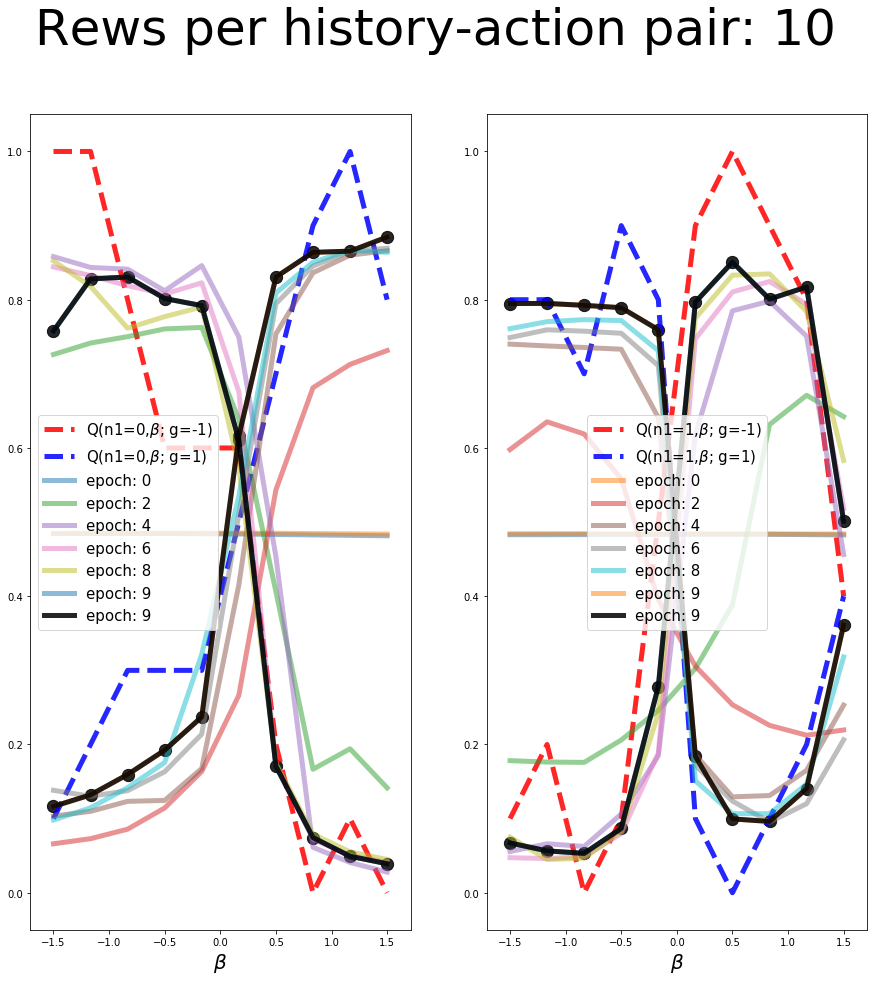

In [19]:
plot_results(histo_preds,mean_values, title="Rews per history-action pair: 10")

## Ok, now let's see what happens when the batch_size is increased.. ##

Real number of splits (len(dataset) after spliting): 200
len(data[0]: 2
Batch size: 2.0
epochs: 20
Number_of_betas: 10
rews_per_beta: 10
Number of data points: 400



Epoch 000: Loss: 0.2518365


Epoch 001: Loss: 0.2506956


Epoch 002: Loss: 0.2502653


Epoch 003: Loss: 0.2495270


Epoch 004: Loss: 0.2478842


Epoch 005: Loss: 0.2442430


Epoch 006: Loss: 0.2385759


Epoch 007: Loss: 0.2378435


Epoch 008: Loss: 0.2362898


Epoch 009: Loss: 0.2361362


Epoch 010: Loss: 0.2353834


Epoch 011: Loss: 0.2345358


Epoch 012: Loss: 0.2343809


Epoch 013: Loss: 0.2330705


Epoch 014: Loss: 0.2334283


Epoch 015: Loss: 0.2328330


Epoch 016: Loss: 0.2320645


Epoch 017: Loss: 0.2310537


Epoch 018: Loss: 0.2315500


Epoch 019: Loss: 0.2309609

Tardé:  0:00:47.186294


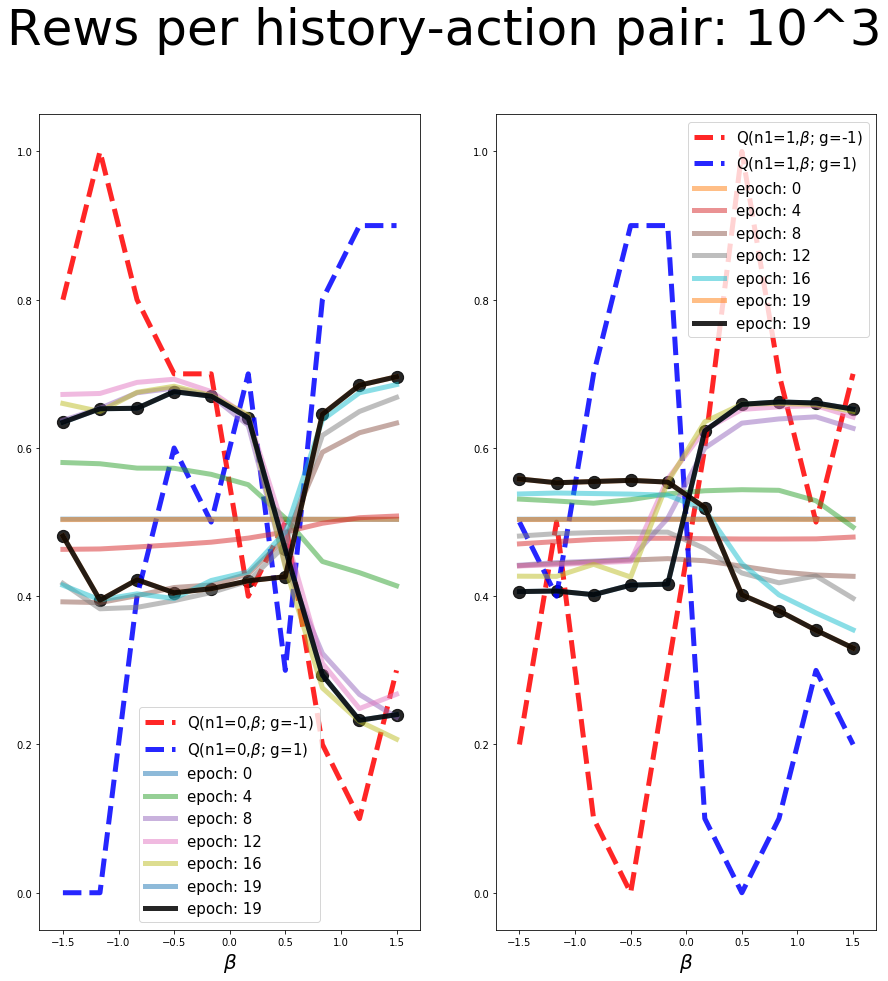

In [21]:
histo_preds1, mean_values1,_ = learning_problem(10,epochs=20, batch_size=2.,number_of_betas=10) 
plot_results(histo_preds1,mean_values1, title="Rews per history-action pair: 10^3")

## Let's go back to the success but now with 100 rewards per beta per guess per outcome##

Training with batch_size of:  20.0


Epoch 000: Loss: 0.204


Epoch 002: Loss: 0.168


Epoch 004: Loss: 0.167


Epoch 006: Loss: 0.165


Epoch 008: Loss: 0.164


Tardé:  0:06:33.245354


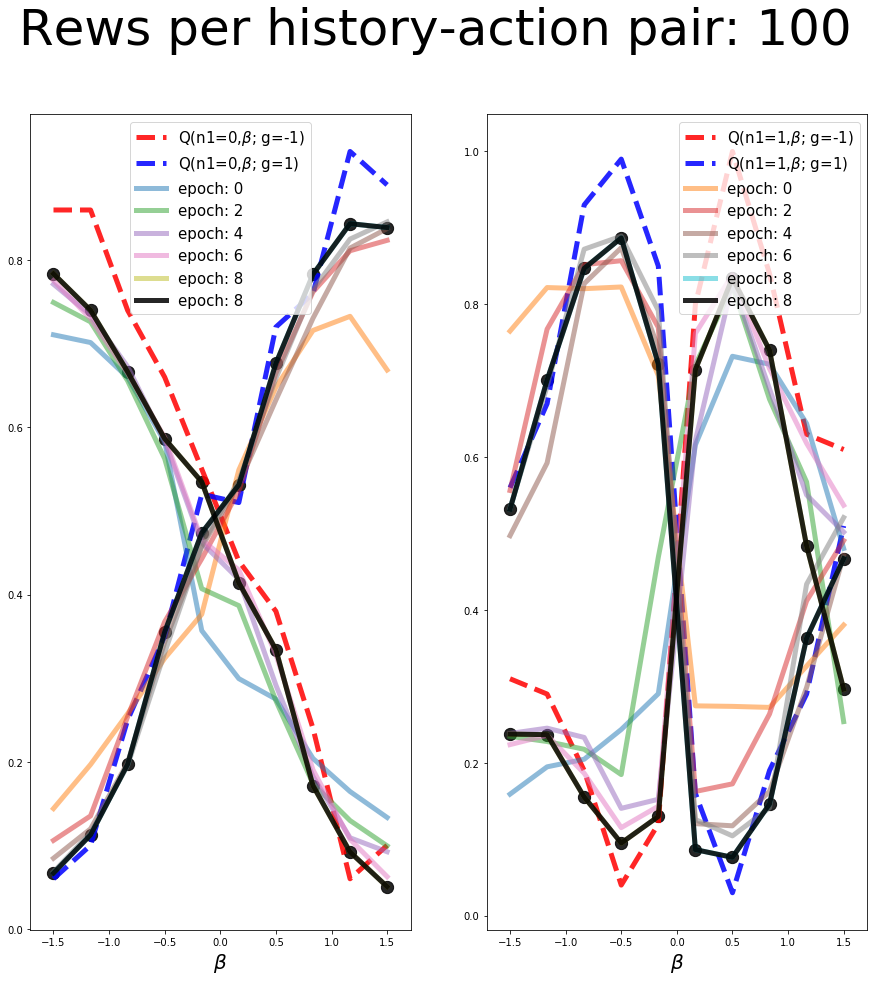

In [158]:
histo_preds1, mean_values1,_ = learning_problem(100,epochs=10, number_of_splits=4000,number_of_betas=10) 
plot_results(histo_preds1,mean_values1, title="Rews per history-action pair: 100")

## not with 2. splits again ##

In [11]:
histo_preds, mean_values, _ ,ee= learning_problem(10,epochs=10, batch_size=1.,number_of_betas=10) 


Real number of splits (len(dataset) after spliting): 400
len(data[0]: 1
Batch size: 1.0
epochs: 10
Number_of_betas: 10
rews_per_beta: 10
Number of data points: 400



Epoch 000: Loss: 0.2505361


Epoch 001: Loss: 0.2495130


Epoch 002: Loss: 0.2296128


Epoch 003: Loss: 0.1958643


Epoch 004: Loss: 0.1885755


Epoch 005: Loss: 0.1824924


Epoch 006: Loss: 0.1804800


Epoch 007: Loss: 0.1805987


Epoch 008: Loss: 0.1775274


Epoch 009: Loss: 0.1762998

Tardé:  0:00:38.381281


[<tf.Variable 'net_1/dense_5/kernel:0' shape=(3, 50) dtype=float64, numpy=
 array([[ 1.60364085e-01,  2.74393514e-04, -2.60071749e-01,
          2.68462588e-03, -1.90678643e-01,  1.10214378e-02,
         -1.11281508e-01, -1.82647873e-01,  3.01572793e-01,
          1.89459997e-01,  1.95971066e-01, -1.19564162e-01,
         -4.05984301e-01,  2.22390902e-01, -1.93329600e-01,
         -1.71630290e-01,  3.35881748e-02, -1.41703092e-02,
         -4.21181845e-02,  1.65996298e-01, -3.49362003e-02,
          2.29522534e-02,  2.81668363e-02, -1.64061682e-01,
         -1.03348128e-01,  1.62833790e-01, -1.51072259e-01,
          2.28414050e-01, -2.86780044e-02, -1.59482300e-01,
         -4.13209208e-02, -2.17215984e-01, -2.33333650e-01,
         -4.58469469e-02, -1.09588403e-01, -2.37610251e-01,
         -5.59140573e-02, -2.73862121e-03, -1.21118833e-01,
         -1.71847186e-01,  1.38261960e-02, -1.41274558e-01,
          1.81060020e-01,  1.12407874e-02,  1.67244431e-01,
         -1.68076764e-01,

In [15]:
for k1,k2 in zip(ee["0"],ee["1"]):
    print(k1-k2)

tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]], shape=(3, 50), dtype=float64)
tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.], shape=(50,), dtype=float64)
tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(50, 50), dtype=float64)
tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.